# Image Generation with AutoEncoders

In [1]:
from data import CelebADataset, PARTITIONS
from models import VAE, GAN
from tensorflow.keras.optimizers.legacy import Adam
import plotly.graph_objects as go 
from IPython.display import HTML
from utils import plot_history, plot_embeds
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt 
import plotly.io as pio 
pio.renderers.default = 'notebook_connected'

2024-05-25 19:53:32.248700: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 19:53:32.281112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 19:53:32.281141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 19:53:32.282173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 19:53:32.287921: I tensorflow/core/platform/cpu_feature_guar

## Table of Contents

1. [Data preprocessing](#data-preprocessing)
2. [Baseline](#baseline)
    - [Variational AutoEncoder](#variational-autoencoder)
    - [WGAN-GP](#wgan-gp)
3. [Modifying the architecture](#modifying-the-architecture)
4. [Exploring the latent space](#exploring-the-latent-space)

## Data preprocessing

We followed the CelebA dataset [official split](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to create a train (80%), validation (10%) and test (10%) subsets. In order to create the same split, the script [data.py](data.py) automatically prepares the dataset subfolders to load and train our models (it is required to previously download the [archive.zip](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) from Kaggle).

In [2]:
# !python3 data.py
train, val, test = map(CelebADataset, ('train', 'val', 'test'))
print(f'Number of train samples: {len(train)}')
print(f'Number of validation samples: {len(val)}')
print(f'Number of test samples: {len(test)}')

Number of train samples: 162770
Number of validation samples: 19867
Number of test samples: 19962


As detailed in the class notebooks, we used two types of normalization methods: in the Variational AutoEncoder (see [vae.py](models/vae.py)) the input images are scaled in the range $[0,1]$ (thus the final activation function is a sigmoid), while the GAN model accepts images in the range $[-1,1]$ and the generator module takes an hyperbolic tangent activation function. For these exercises, we used a resolution of $128\times 128$ to generate RGB images.


## Baseline 

### Variational AutoEncoder 

The Variational AutoEncoder ([Pu et al., 2016](https://proceedings.neurips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Paper.pdf)) is implemented in the script [vae.py](models/vae.py). The class `VAE` accepts the following hyperparameters:

- `img_size`: Image dimensions to feed the VAE. In this case, we used RGB images of dimension $128\times 128$.
- `hidden_size`: Dimension of the latent space. 
- `pool`: If `strides`, it uses doube-strides as a pooling method. If `dilation`, it uses a dilation rate of 2 followed by a max-pooling or up-sampling of factor 2.
- `residual`: Whether to use residual blocks.

The default configuration (used in class notebooks) uses a latent space of dimension $d_h = 200$ with double-strides and no residual nor skip connections:

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
vae = VAE(CelebADataset.IMG_SIZE, hidden_size=200, pool='strides', residual=False)

Instructions for updating:
Colocations handled automatically by placer.


2024-05-25 19:53:39.291828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-05-25 19:53:39.291939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22324 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-05-25 19:53:39.431569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-25 19:53:39.878991: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_54/kernel/Assign' id:3449 op device:{requested: '', assigned: ''} def:{{{node conv2d_54/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_54/kernel, conv2d_54/kernel/Initializer/stateless_ra

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder-input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1 (ConvBlock)           (None, 32, 32, 64)           1792      ['encoder-input[0][0]']       
                                                                                                  
 conv2 (ConvBlock)           (None, 16, 16, 128)          73856     ['conv1[0][0]']               
                                                                                                  
 conv3 (ConvBlock)           (None, 8, 8, 256)            295168    ['conv2[0][0]']               
                                                                                            

The `train()` method of the class `VAE` allows fitting the Keras model with the following hyperparameters:

- `train`: CelebA dataset instance with the training set.
- `val`: CelebA dataset instance with the validation set (used to track the losses and FID score).
- `test`: CelebA dataset instance with the evaluation set (used to save the final generated images).
- `path`: Folder to store all the training results.
- `batch_size`: Batch size.
- `epochs`: Number of training epochs. Default to 10.
- `train_patience`: Number of allowed epochs with no training improvement. Defaults to 5.
- `val_patience`: Number of allowed epochs with no validation improvement. Defaults to 5.
- `steps_per_epoch`: Number of batches per epoch. Defaults to 1500.
- `optimizer`: Keras Optimizer. Defaults to Adam with learning rate $\eta=10^{-4}$.


At training and validation time, the Keras API displays the performance of the model in the train and validation set in the following metrics:

- `r_loss`: Defined as the mean squared error between the real and generated image.
- `kl_loss`: Defined as the KL divergence loss in the latent space.
- `fid`: FID score computed with the [InceptionV3](https://keras.io/api/applications/inceptionv3/). Due to our computational limits, at training time we used a split of 500 samples to compute each FID score, resizing the images to $256\times 256$ resolution.

In [5]:
vae_history = vae.train(train, val, test, 'results/vae/', optimizer=Adam(5e-4), epochs=10)

Found 162770 files belonging to 1 classes.
Found 19867 files belonging to 1 classes.


inception:   0%|          | 0/7 [00:00<?, ?it/s]2024-05-25 19:55:34.083549: W tensorflow/c/c_api.cc:305] Operation '{name:'count_4/Assign' id:8339 op device:{requested: '', assigned: ''} def:{{{node count_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_4, count_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-25 19:55:39.665010: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:8419 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runnin

Train on 1500 steps, validate on 1500 steps
Epoch 1/10
1498/1500 [============================>.] - ETA: 0s - batch: 748.5000 - size: 1.0000 - loss: 51.4341 - r_loss: 0.0416 - kl_loss: 9.8283

2024-05-25 19:55:47.666929: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:8419 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-25 19:55:50.905796: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/output/Sigmoid' id:404 op device:{requested: '', assigned: ''} def:{{{node decoder/output/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/output/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1500/1500 [==============================] - 52s 34ms/step - batch: 749.5000 - size: 1.0000 - loss: 51.4278 - r_loss: 0.0416 - kl_loss: 9.8279 - val_loss: 49.0869 - val_r_loss: 0.0396 - val_kl_loss: 9.4988 - fid: 344.8651 - val_fid: 340.8104
Epoch 2/10
1494/1500 [============================>.] - ETA: 0s - batch: 746.5000 - size: 1.0000 - loss: 46.8464 - r_loss: 0.0368 - kl_loss: 10.0383

1500/1500 [==============================] - 33s 22ms/step - batch: 749.5000 - size: 1.0000 - loss: 46.8291 - r_loss: 0.0368 - kl_loss: 10.0352 - val_loss: 43.9121 - val_r_loss: 0.0345 - val_kl_loss: 9.4164 - fid: 342.9133 - val_fid: 344.4112
Epoch 3/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 43.1762 - r_loss: 0.0333 - kl_loss: 9.9070

1500/1500 [==============================] - 128s 85ms/step - batch: 749.5000 - size: 1.0000 - loss: 43.1689 - r_loss: 0.0333 - kl_loss: 9.9057 - val_loss: 42.1113 - val_r_loss: 0.0327 - val_kl_loss: 9.3717 - fid: 334.2555 - val_fid: 336.4527
Epoch 4/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: 42.4398 - r_loss: 0.0326 - kl_loss: 9.8759

1500/1500 [==============================] - 51s 34ms/step - batch: 749.5000 - size: 1.0000 - loss: 42.4394 - r_loss: 0.0326 - kl_loss: 9.8765 - val_loss: 41.8278 - val_r_loss: 0.0319 - val_kl_loss: 9.9435 - fid: 335.3972 - val_fid: 338.6935
Epoch 5/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 42.1898 - r_loss: 0.0322 - kl_loss: 9.9865

1500/1500 [==============================] - 34s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 42.1943 - r_loss: 0.0322 - kl_loss: 9.9873 - val_loss: 41.3622 - val_r_loss: 0.0313 - val_kl_loss: 10.0532 - fid: 330.7940 - val_fid: 330.5568
Epoch 6/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: 41.7273 - r_loss: 0.0317 - kl_loss: 10.0271

1500/1500 [==============================] - 143s 96ms/step - batch: 749.5000 - size: 1.0000 - loss: 41.7262 - r_loss: 0.0317 - kl_loss: 10.0279 - val_loss: 41.2170 - val_r_loss: 0.0311 - val_kl_loss: 10.0998 - fid: 331.1779 - val_fid: 332.2928
Epoch 7/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: 41.2979 - r_loss: 0.0312 - kl_loss: 10.1033

1500/1500 [==============================] - 35s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 41.2946 - r_loss: 0.0312 - kl_loss: 10.1043 - val_loss: 40.9941 - val_r_loss: 0.0307 - val_kl_loss: 10.3382 - fid: 333.1870 - val_fid: 335.6473
Epoch 8/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: 40.8940 - r_loss: 0.0308 - kl_loss: 10.0754

1500/1500 [==============================] - 33s 22ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.9046 - r_loss: 0.0308 - kl_loss: 10.0774 - val_loss: 41.1921 - val_r_loss: 0.0314 - val_kl_loss: 9.7615 - fid: 328.3212 - val_fid: 328.8821
Epoch 9/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: 40.9673 - r_loss: 0.0308 - kl_loss: 10.1495

1500/1500 [==============================] - 72s 48ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.9679 - r_loss: 0.0308 - kl_loss: 10.1510 - val_loss: 40.6346 - val_r_loss: 0.0296 - val_kl_loss: 10.9854 - fid: 329.9222 - val_fid: 329.0367
Epoch 10/10
1500/1500 [==============================] - ETA: 0s - batch: 749.5000 - size: 1.0000 - loss: 40.8094 - r_loss: 0.0306 - kl_loss: 10.2034

1500/1500 [==============================] - 35s 23ms/step - batch: 749.5000 - size: 1.0000 - loss: 40.8094 - r_loss: 0.0306 - kl_loss: 10.2034 - val_loss: 40.5896 - val_r_loss: 0.0297 - val_kl_loss: 10.8554 - fid: 324.8159 - val_fid: 322.2871


Once the training has ended, the folder used as the `path` variable will store the following elements:

```
results/
    vae/    
        model.h5 
        history.pkl
        results.pkl
        epoch-preds/
            ...
        test-preds/
            ...
```

- [model.h5](results/vae/model.h5): The best model weights in terms of FID score in the validation set.
- [history.pkl](results/vae/history.pkl): The training history (losses and metrics).
- [results.pkl](results/vae/results.pkl): The final FID score of each set.
- [val-preds](results/vae/val-preds/): The generated images of the validation set during the training process (by default, 100 images are saved per epoch).
- [test-preds](results/vae/test-preds): The generated images of the test set at the end of the trainingprocess, with the best weight configuration.

The function `plot_history()` (see [utils.py](utils.py)) displays the progress of a given measure during the training stage.

In [ ]:
plot_history(vae_history, 'loss').show()
plot_history(vae_history, 'kl_loss').show()
plot_history(vae_history, 'r_loss').show()
plot_history(vae_history, 'fid').show()

Finally, we can use the `display()` function (see [utils.py](utils.py)) to display the images generated by the VAE.

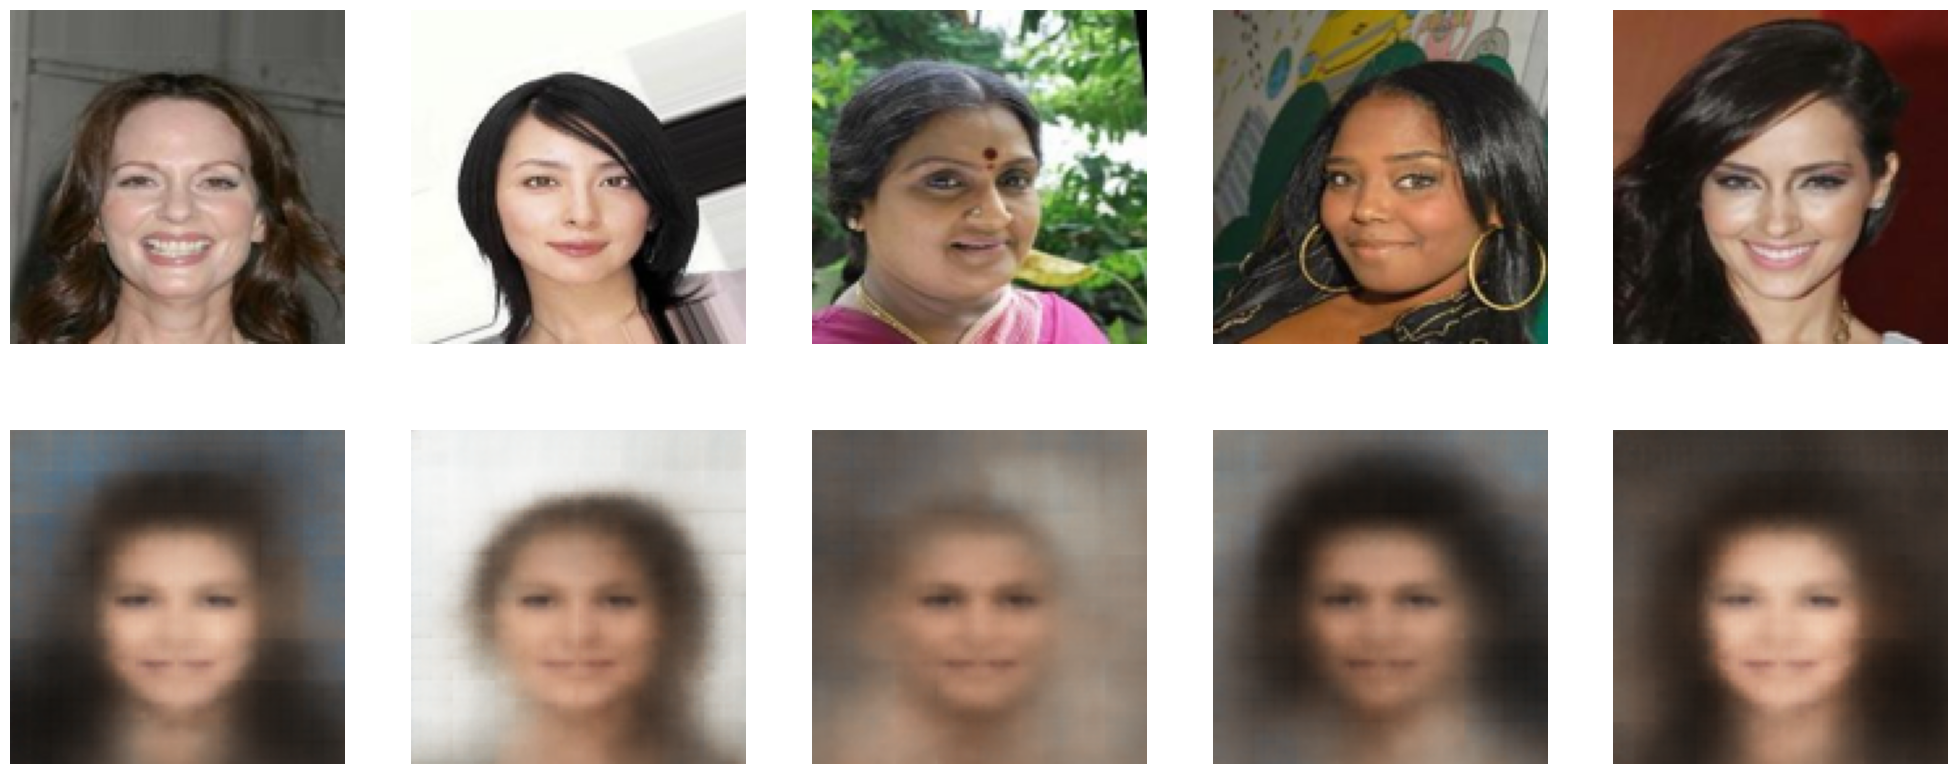

In [8]:
real = next(test.stream(vae.NORM, 5))[1]
fake = vae.model.predict(real, verbose=0)
display(*map(vae.DENORM, (real, fake)))

### WGAN-GP

Similarly, we used the implementation of the class notebooks to create a baseline with the WGAN-GP ([Arjovsky et al., 2017](https://arxiv.org/abs/1701.07875)). The class `GAN` (implemented in [gan.py](models/gan.py)) builds and trains the adversarial model with the specific callbacks and metrics. This class accepts the following arguments:

- `img_size`: Image size. For these exercises, we selected RGB images with resolution $128\times 128$.
- `hidden_size`: Dimension of the latent space.
- `pool`: Type of pooling ot use in the generator and discriminator. If `strides`, it uses convolutions with double-strides. If `dilation` it uses dilated convolutions followed by max-pooling or up-sampling. By default `strides`.
- `residual`: Whether to use residual blocks. By default it uses standard convolutional blocks.
- `critic_steps`: Number of steps training the discriminator before optimizing the generator.
- `gp_weight`: Optimization hyperparameter in the gradient penalty.

In [5]:
wgan = GAN(CelebADataset.IMG_SIZE, hidden_size = 128, pool='strides', residual=False, critic_steps=3, gp_weight=10)

To train the GAN model the smae arguments as explained in the VAE implementation must be used:

In [6]:
wgan_history = wgan.train(train, val, test, path='results/wgan', batch_size=20, epochs=10)

Found 162770 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a1f3cd652d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a1f3cd652d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Found 19867 files belonging to 1 classes.


inception:   0%|          | 0/50 [00:00<?, ?it/s]2024-05-24 16:06:13.976071: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Epoch 1/10


2024-05-24 16:06:25.261341: I external/local_xla/xla/service/service.cc:168] XLA service 0x5a3e09d44a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-24 16:06:25.261363: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-24 16:06:25.261367: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-24 16:06:25.267984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716559585.363076  502984 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - ETA: 0s - c_loss: -2.8608 - c_wass_loss: -3.4819 - c_gp: 0.0621 - g_loss: 8.3531 - c_acc: 15.6801 - g_acc: 95.9855

1500/1500 [==============================] - 531s 351ms/step - c_loss: -2.8608 - c_wass_loss: -3.4819 - c_gp: 0.0621 - g_loss: 8.3531 - c_acc: 15.6705 - g_acc: 95.9881 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 374.6558 - val_fid: 372.9523
Epoch 2/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.7196 - c_wass_loss: -0.7840 - c_gp: 0.0064 - g_loss: 5.6114 - c_acc: 0.9301 - g_acc: 99.3868

1500/1500 [==============================] - 530s 353ms/step - c_loss: -0.7196 - c_wass_loss: -0.7840 - c_gp: 0.0064 - g_loss: 5.6114 - c_acc: 0.9319 - g_acc: 99.3869 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 402.8370 - val_fid: 400.5402
Epoch 3/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.2087 - c_wass_loss: -1.3187 - c_gp: 0.0110 - g_loss: 3.4947 - c_acc: 15.1255 - g_acc: 91.8309

1500/1500 [==============================] - 528s 352ms/step - c_loss: -1.2087 - c_wass_loss: -1.3187 - c_gp: 0.0110 - g_loss: 3.4947 - c_acc: 15.1356 - g_acc: 91.8189 - val_c_acc: 0.0000e+00 - val_g_acc: 100.0000 - fid: 408.8687 - val_fid: 406.1084
Epoch 4/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.8362 - c_wass_loss: -0.8864 - c_gp: 0.0050 - g_loss: 2.7144 - c_acc: 29.4165 - g_acc: 79.6204

1500/1500 [==============================] - 525s 350ms/step - c_loss: -0.8362 - c_wass_loss: -0.8864 - c_gp: 0.0050 - g_loss: 2.7144 - c_acc: 29.4149 - g_acc: 79.6254 - val_c_acc: 2.2000 - val_g_acc: 100.0000 - fid: 490.2902 - val_fid: 482.3736
Epoch 5/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9129 - c_wass_loss: -0.9669 - c_gp: 0.0054 - g_loss: 1.4458 - c_acc: 42.9939 - g_acc: 72.4017

1500/1500 [==============================] - 531s 354ms/step - c_loss: -0.9129 - c_wass_loss: -0.9669 - c_gp: 0.0054 - g_loss: 1.4458 - c_acc: 43.0167 - g_acc: 72.3857 - val_c_acc: 100.0000 - val_g_acc: 48.6000 - fid: 502.4674 - val_fid: 498.0322
Epoch 6/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9461 - c_wass_loss: -1.0052 - c_gp: 0.0059 - g_loss: 0.2246 - c_acc: 66.9077 - g_acc: 54.9823

1500/1500 [==============================] - 534s 356ms/step - c_loss: -0.9461 - c_wass_loss: -1.0052 - c_gp: 0.0059 - g_loss: 0.2246 - c_acc: 66.9147 - g_acc: 54.9793 - val_c_acc: 99.6000 - val_g_acc: 60.4000 - fid: 469.1463 - val_fid: 464.2170
Epoch 7/10
1500/1500 [==============================] - ETA: 0s - c_loss: -0.9770 - c_wass_loss: -1.0419 - c_gp: 0.0065 - g_loss: 0.5904 - c_acc: 65.7503 - g_acc: 70.0368

1500/1500 [==============================] - 535s 356ms/step - c_loss: -0.9770 - c_wass_loss: -1.0419 - c_gp: 0.0065 - g_loss: 0.5904 - c_acc: 65.7523 - g_acc: 70.0353 - val_c_acc: 86.6000 - val_g_acc: 96.8000 - fid: 462.3430 - val_fid: 472.8241
Epoch 8/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.2337 - c_wass_loss: -1.3293 - c_gp: 0.0096 - g_loss: 1.8328 - c_acc: 37.8011 - g_acc: 83.6471

1500/1500 [==============================] - 534s 356ms/step - c_loss: -1.2337 - c_wass_loss: -1.3293 - c_gp: 0.0096 - g_loss: 1.8328 - c_acc: 37.7920 - g_acc: 83.6517 - val_c_acc: 0.4000 - val_g_acc: 100.0000 - fid: 456.8448 - val_fid: 454.1087
Epoch 9/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.0129 - c_wass_loss: -1.0739 - c_gp: 0.0061 - g_loss: 2.3282 - c_acc: 23.2813 - g_acc: 91.6023

1500/1500 [==============================] - 528s 352ms/step - c_loss: -1.0129 - c_wass_loss: -1.0739 - c_gp: 0.0061 - g_loss: 2.3282 - c_acc: 23.2863 - g_acc: 91.5991 - val_c_acc: 5.8000 - val_g_acc: 100.0000 - fid: 433.3018 - val_fid: 429.7416
Epoch 10/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1.0229 - c_wass_loss: -1.0896 - c_gp: 0.0067 - g_loss: 1.5077 - c_acc: 37.4816 - g_acc: 90.7917

1500/1500 [==============================] - 526s 351ms/step - c_loss: -1.0229 - c_wass_loss: -1.0896 - c_gp: 0.0067 - g_loss: 1.5077 - c_acc: 37.5001 - g_acc: 90.7891 - val_c_acc: 61.4000 - val_g_acc: 100.0000 - fid: 446.2078 - val_fid: 445.7891


In [10]:
plot_history(wgan_history, name=['c_acc', 'g_acc', 'val_c_acc', 'val_g_acc']).update_xaxes(title_text='acc')
plot_history(wgan_history, name='fid')

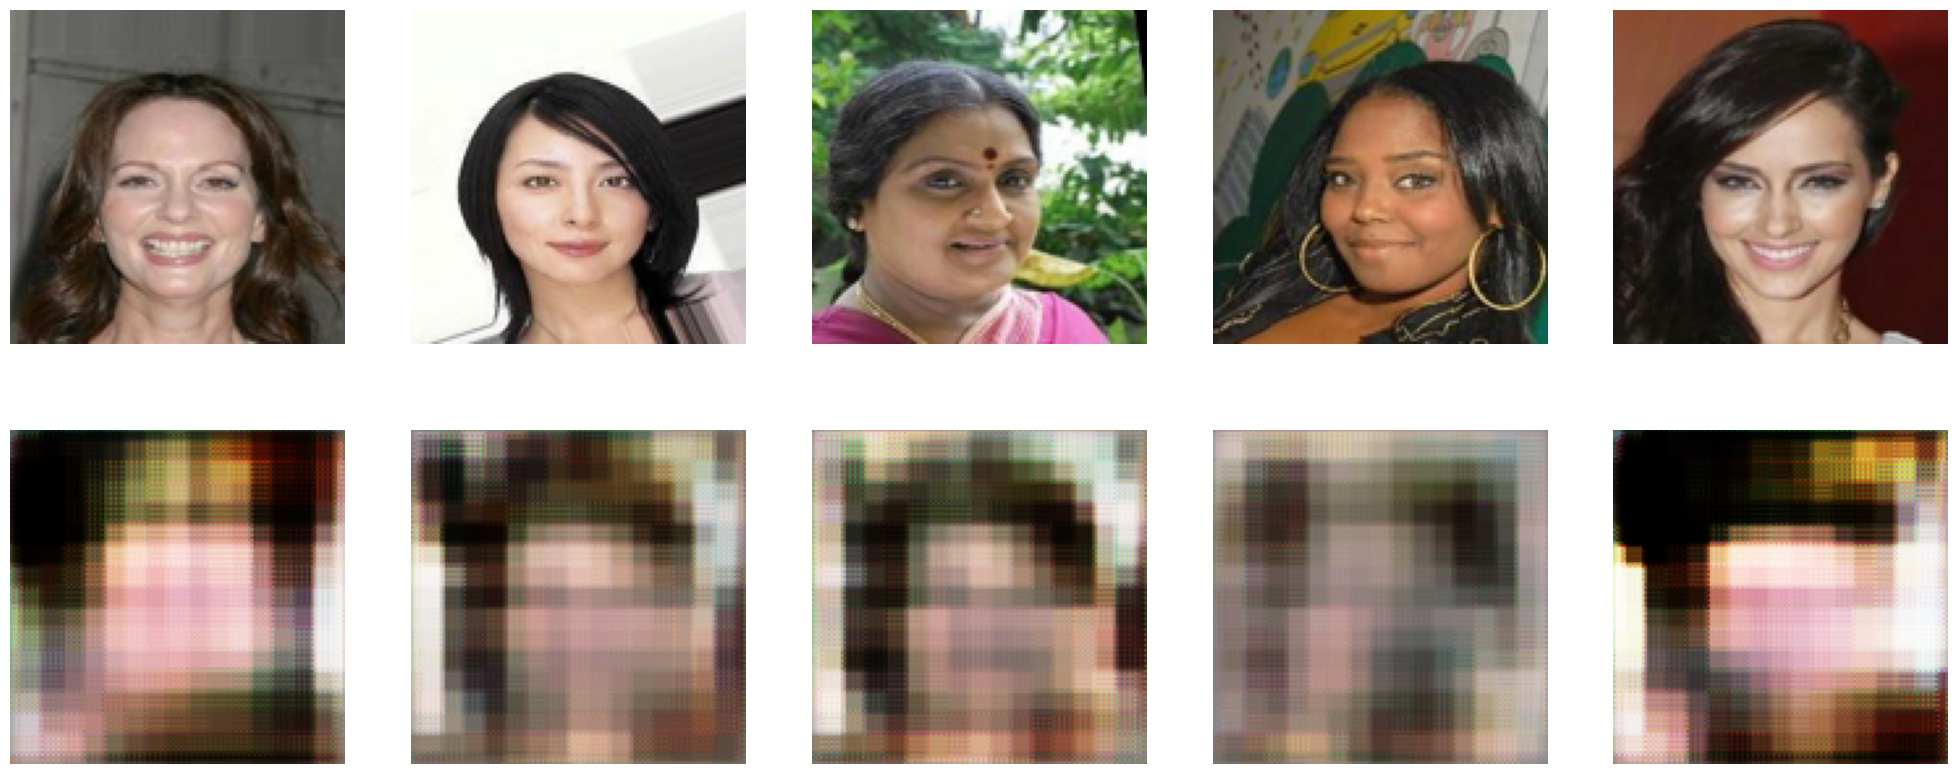

In [21]:
real = next(test.stream(wgan.NORM, 5))[1]
fake = wgan.model(real)
display(*map(wgan.DENORM, (real, fake)))

We see that the baseline models do not reach acceptable results in image generation. In the next sections we show our results when varying the architecture and extending the training time.

## Modifying the architecture

In the previous demonstration of the generative baselines we used a limited latent space ($d_h^\text{(vae)} = 200$ and $d_h^\text{(wgan)}=128$) and training time. In order to test the capacities of the VAE and WGAN-GP models, we performed experiments increasing the dimension of the latent space ($\{128, 256, 512\}$), using residual blocks instead of standard convolutions and increasing the dilation of the convolutional layers to expand the receptive field of the network. To facilitate readibility of this notebook, we do not include the Keras output of each model, but a summary of the performance obtained with each configuration. Similar results can be reproduced followng the [README.md](README.md) file attached with the code.


FID scores obtained with VAE:

| $d_h$        | pool         | residual     | train        | val          | test         |
|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| 128          | *strides*    | -            | 212.66       | 215.97       | 209.84       |
| 256          | *strides*    | -            |              |              |              |
| 512          | *strides*    | -            |              |              |              |
| 512          | *dilation*   | -            |              |              |              |
| 512          | *strides*    | +            |              |              |              |
| 512          | *dilation*   | +            |              |              |              |



FID scores obtained with WGAN-GP:

| $d_h$        | pool         | residual     | train        | val          | test         |
|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| 128          | *strides*    | -            |              |              |              |
| 256          | *strides*    | -            |              |              |              |
| 512          | *strides*    | -            |              |              |              |
| 512          | *dilation*   | -            |              |              |              |
| 512          | *strides*    | +            |              |              |              |
| 512          | *dilation*   | +            |              |              |              |

## Exploring the latent space 

In order to explore the latent space obtained in each model we visualized the contextualized vector obtained with each model (VAE and GAN) projected into a 3-dimensional space. With the aim of grouping the different projections of the input images, we relied on the annotations provided in the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) about different characteristics of the person recorded in each image. 

The [list_attr_celeba.csv](archive/list_attr_celeba.csv) file contains binary features of each image (such as gender, hairstyle, eyeglasses, age, facial characteristics, etc.). In order to evaluate the VAE latent space we can classify some images in different categories (for instance, by hairstyle) and project their embeddings into a representable space (e.g. 2 or 3 dimensions). For this purpose, we used t-SNE ([Maaten et al., 2008](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)) to project the set of selected embeddings of dimension $d_h^\text{(vae)}$ and represented them in a 3-dimensional space.

In [4]:
info = pd.read_csv('archive/list_attr_celeba.csv', index_col=0)
partition = pd.read_csv('archive/list_eval_partition.csv', index_col=0)
info = info.join(partition)
info.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'partition'],
      dtype='object')

The next cell loads the pretrained weights of the VAE generator with $d_h=512$ and selects 200 instances for each category (`Bald`, `Black_Hair`, `Blond_hair`, `Brown Hair`, `Gray_Hair`). Then, obtains the latent vectors of each image and displays them in a 3-dimensional space (projected with [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)):

In [6]:
vae = VAE(CelebADataset.IMG_SIZE, hidden_size=512, pool='strides', residual=False)
vae.model.load_weights('results/vae/vae_512_strides/model.h5')
categories = ['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
LIMIT = 200
images, labels = [], []
for c in categories:
    selection = info[info[c] == 1].copy()
    # drop 
    for other in categories:
        if c != other:
            selection = selection[selection[other] == -1]
    selection = selection[:LIMIT]
    images += [f'archive/{PARTITIONS[partition]}/{file}' for file, partition in zip(selection.index, selection.partition)]
    labels += [c for _ in range(LIMIT)] 
embed = vae.latent(images)

lda = LDA(n_components=3)
proj = lda.fit_transform(np.stack(embed), np.array(labels))
fig = plot_embeds(proj, categories)
fig.show()

This visualization allows us to qualitatively assess the organization of the latent space of the VAE model when introducing images with different characteristics. We see that some groups  like `Brown_Hair` and `Black_Hair` look more "intermixed" than others (for instance, the `Bald` group is completly separated from `Black_Hair` and `Brown_Hair`). We see that groups like `Blond_Hair`, `Gray_Hair` and `Black_Hair` have more outliers in their projected distribution than the group `Bald` and `Brown_Hair`. This might suggest that in those groups with more outliers there are some data samples that the VAE encoder is able to better discriminate than those groups that do not have many outliers (which matches with our perception of diversity in persons with no hair: we expect less variability in images of celebrities with no hair than celebrities with hair).

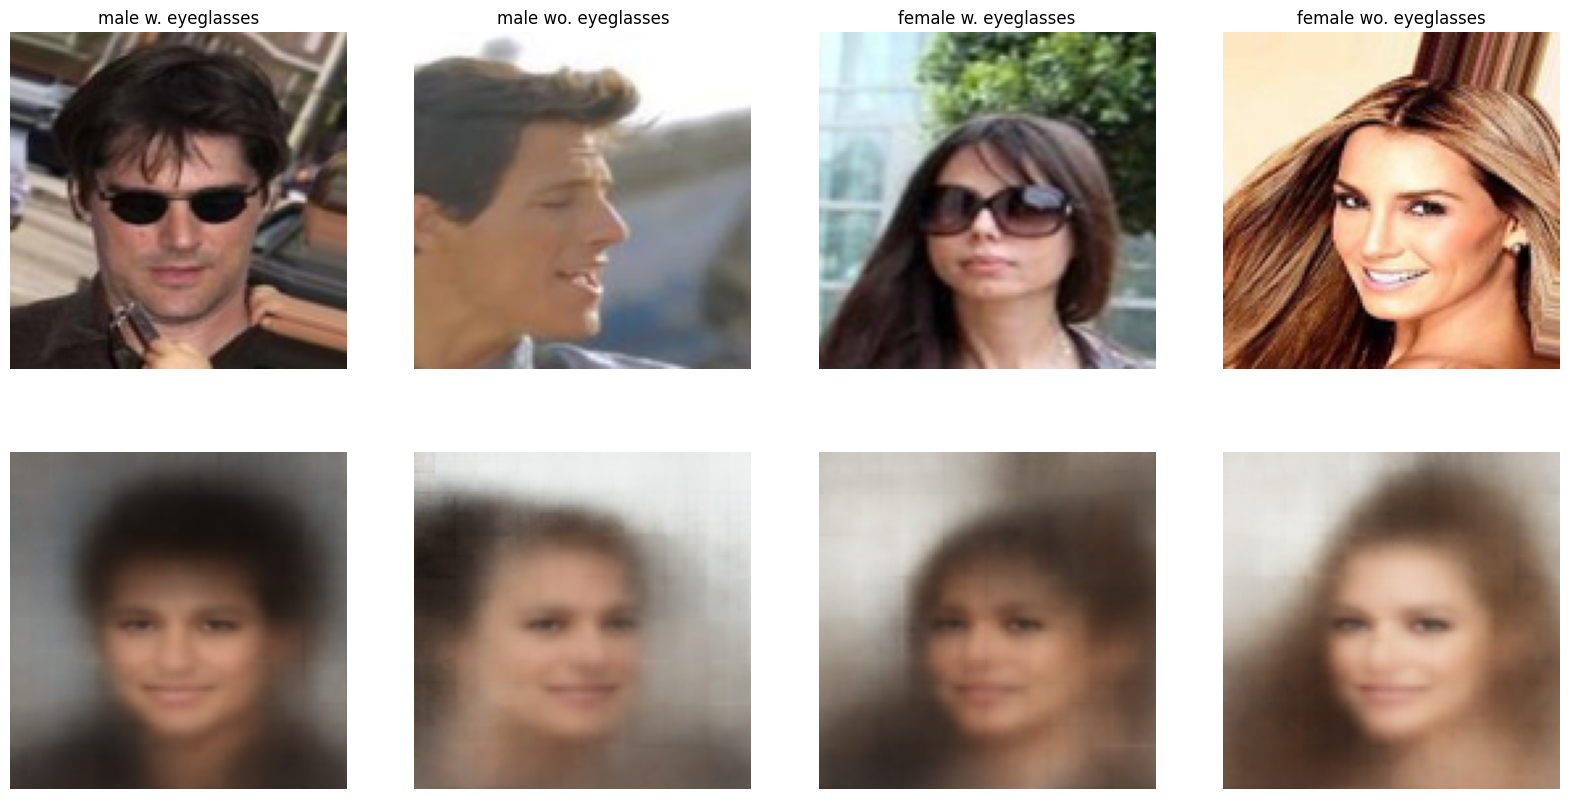

In [20]:
LIMIT = 50
get_paths = lambda df: [f'archive/{PARTITIONS[part]}/{file}' for file, part in zip(df.index, df.partition)]
load_img = lambda path: np.array(Image.open(path).resize(CelebADataset.IMG_SIZE[:2]))

male_eye = get_paths(info[(info.Male == 1) & (info.Eyeglasses == 1)][:LIMIT])
male_noeye = get_paths(info[(info.Male == 1) & (info.Eyeglasses == -1)][:LIMIT])
female_eye = get_paths(info[(info.Male == -1) & (info.Eyeglasses == 1)][:LIMIT])
female_noeye = get_paths(info[(info.Male == -1) & (info.Eyeglasses == -1)][:LIMIT])

fig, ax = plt.subplots(2, 4, figsize=(5*4, 10))
ax[0,0].imshow(load_img(male_eye[0])); ax[0,0].set_axis_off(); ax[0,0].set_title('male w. eyeglasses')
ax[0,1].imshow(load_img(male_noeye[0])); ax[0,1].set_axis_off(); ax[0,1].set_title('male wo. eyeglasses')
ax[0,2].imshow(load_img(female_eye[0])); ax[0,2].set_axis_off(); ax[0,2].set_title('female w. eyeglasses')
ax[0,3].imshow(load_img(female_noeye[0])); ax[0,3].set_axis_off(); ax[0,3].set_title('female wo. eyeglasses')

preds = vae.generate([male_eye[0], male_noeye[0], female_eye[0], female_noeye[0]])
ax[1,0].imshow(preds[0]); ax[1,0].set_axis_off()
ax[1,1].imshow(preds[1]); ax[1,1].set_axis_off()
ax[1,2].imshow(preds[2]); ax[1,2].set_axis_off()
ax[1,3].imshow(preds[3]); ax[1,3].set_axis_off()